<center><strong>中文自然语言处理</strong></center>
<center><strong>Transformer模型(一)</strong></center>

说到自然语言处理, 语言模型, 命名实体识别, 机器翻译, 可能很多人想到的**LSTM等循环神经网络**, 但目前其实LSTM起码在自然语言处理领域已经过时了, 在Stanford阅读理解数据集**(SQuAD2.0)**榜单里, 机器的成绩已经超人类表现, 这很大程度要归功于**transformer的BERT预训练模型**.    
今天我们来讲一下**transformer模型**, 你不需要有很多深度学习和数学基础, 我来用简单的语言和可视化的方法从零讲起.   
transformer是谷歌大脑在2017年底发表的论文**attention is all you need**中所提出的seq2seq模型. 现在已经取得了大范围的应用和扩展, 而BERT就是从transformer中衍生出来的预训练语言模型.    

在我们开始之前, 允许我简单说一下目前自然语言处理领域的现状, 目前**transformer**模型已经得到广泛认可和应用, 而应用的方式主要是先进行**预训练语言模型**, 然后把预训练的模型适配给下游任务, 以完成各种不同的任务, 如分类, 生成, 标记等等, 预训练模型非常重要, 预训练的模型的性能直接影响下游任务的性能, 通过我制作的这几期视频, 我有信心让小伙伴们充分理解transformer并具备一定衍生模型的设计和编写能力.

为了让大家充分理解和初步使用transformer和训练BERT, 并应用到自己的需求上, 这个连载课程将包括以下几个视频来完成, 今天讲解第一部分:    
__一. transformer编码器(理论部分)__:
0. $transformer$模型的直觉, 建立直观认识;
1. $positional \ encoding$, 即**位置嵌入**(或位置编码);
2. $self \ attention \ mechanism$, 即**自注意力机制**与**注意力矩阵可视化**;
3. $Layer \ Normalization$和残差连接.
4. $transformer \ encoder$整体结构.   

__二. transformer代码解读, 语料数据预处理, BERT的预训练和情感分析的应用__:

__三. sequence 2 sequence(序列到序列)模型或Name Entity Recognition(命名实体识别)(待定)__:   
此部分根据前面的反馈待定.

## 0. $transformer$模型的直觉, 建立直观认识;

首先来说一下**transformer**和**LSTM**的最大区别, 就是LSTM的训练是迭代的, 是一个接一个字的来, 当前这个字过完LSTM单元, 才可以进下一个字, 而transformer的训练是并行了, 就是所有字是全部同时训练的, 这样就大大加快了计算效率, transformer使用了位置嵌入$(positional \ encoding)$来理解语言的顺序, 使用自注意力机制和全连接层来进行计算, 这些后面都会详细讲解.   
transformer模型主要分为**两大部分**, 分别是**编码器**和**解码器**, **编码器**负责把自然语言序列映射成为**隐藏层**(下图中**第2步**用九宫格比喻的部分), 含有自然语言序列的数学表达. 然后解码器把隐藏层再映射为自然语言序列, 从而使我们可以解决各种问题, 如情感分类, 命名实体识别, 语义关系抽取, 摘要生成, 机器翻译等等, 下面我们简单说一下下图的每一步都做了什么:   
1. 输入自然语言序列到编码器: Why do we work?(为什么要工作);
2. 编码器输出的隐藏层, 再输入到解码器;
3. 输入$<start>$(起始)符号到解码器;
4. 得到第一个字"为";
5. 将得到的第一个字"为"落下来再输入到解码器;
6. 得到第二个字"什";
7. 将得到的第二字再落下来, 直到解码器输出$<end>$(终止符), 即序列生成完成.

![](./imgs/intuition.jpg)

我们这节课的内容限于**编码器**部分, 即把**自然语言序列映射为隐藏层的数学表达的过程**, 因为理解了编码器中的结构, 理解解码器就非常简单了,最重要的是**BERT预训练模型**只用到了编码器的部分, 也就是先用编码器训练一个语言模型, 然后再把它适配给其他五花八门的任务.   
如果你不知道**语言模型**是什么, 没关系, 这丝毫不影响本节课内容的理解, 下次我们讲**BERT**的时候会讲.   
而且我们用编码器就能够完成一些自然语言处理中比较主流的任务, 如情感分类, 语义关系分析, 命名实体识别等, 解码器的内容和序列到序列模型有机会我们会涉及到.

### Transformer Block结构图,   注意: 为方便查看, 下面的内容分别对应着上图第1, 2, 3, 4个方框的序号:

![](./imgs/encoder.jpg)

## 1. $positional \ encoding$, 即**位置嵌入**(或位置编码);

由于transformer模型**没有**循环神经网络的迭代操作, 所以我们必须提供每个字的位置信息给transformer, 才能识别出语言中的顺序关系.   
现在定义一个位置嵌入的概念, 也就是$positional \ encoding$, 位置嵌入的维度为$[max \ sequence \ length, \ embedding \ dimension]$, 嵌入的维度同词向量的维度, $max \ sequence \ length$属于超参数, 指的是限定的最大单个句长.   
注意, 我们一般以字为单位训练transformer模型, 也就是说我们不用分词了, 首先我们要初始化字向量为$[vocab \ size, \ embedding \ dimension]$, $vocab \ size$为总共的字库数量, $embedding \ dimension$为字向量的维度, 也是每个字的数学表达.    
在这里论文中使用了$sine$和$cosine$函数的线性变换来提供给模型位置信息:   
$$PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}}) \quad PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})\tag{eq.1}$$
上式中$pos$指的是句中字的位置, 取值范围是$[0, \ max \ sequence \ length)$, $i$指的是词向量的维度, 取值范围是$[0, \ embedding \ dimension)$, 上面有$sin$和$cos$一组公式, 也就是对应着$embedding \ dimension$维度的一组奇数和偶数的序号的维度, 例如$0, 1$一组, $2, 3$一组, 分别用上面的$sin$和$cos$函数做处理, 从而产生不同的周期性变化, 而位置嵌入在$embedding \ dimension$维度上随着维度序号增大, 周期变化会越来越慢, 而产生一种包含位置信息的纹理  
就像论文原文中第六页讲的, 位置嵌入函数的周期从$2 \pi$到$10000 * 2 \pi$变化, 而每一个位置在$embedding \ dimension$维度上都会得到不同周期的$sin$和$cos$函数的取值组合, 从而产生独一的纹理位置信息, 模型从而学到位置之间的依赖关系和自然语言的时序特性.   
下面画一下位置嵌入, 可见纵向观察, 随着$embedding \ dimension$增大, 位置嵌入函数呈现不同的周期变化.

In [1]:
# 导入依赖库
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
def get_positional_encoding(max_seq_len, embed_dim):
    # 初始化一个positional encoding
    # embed_dim: 字嵌入的维度
    # max_seq_len: 最大的序列长度
    positional_encoding = np.array([
        [pos / np.power(10000, 2 * i / embed_dim) for i in range(embed_dim)]
        if pos != 0 else np.zeros(embed_dim) for pos in range(max_seq_len)])
    positional_encoding[1:, 0::2] = np.sin(positional_encoding[1:, 0::2])  # dim 2i 偶数
    positional_encoding[1:, 1::2] = np.cos(positional_encoding[1:, 1::2])  # dim 2i+1 奇数
    # 归一化, 用位置嵌入的每一行除以它的模长
    # denominator = np.sqrt(np.sum(position_enc**2, axis=1, keepdims=True))
    # position_enc = position_enc / (denominator + 1e-8)
    return positional_encoding

Text(69.0, 0.5, 'sequence length')

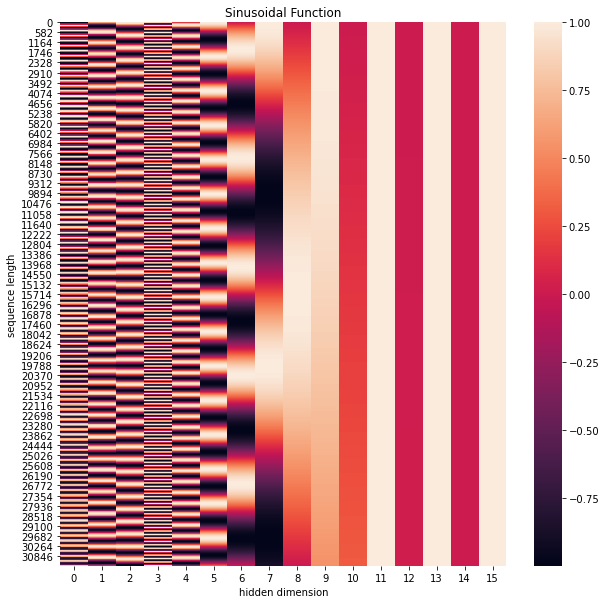

In [10]:
positional_encoding = get_positional_encoding(max_seq_len=round(10000*math.pi), embed_dim=16)
plt.figure(figsize=(10,10))
sns.heatmap(positional_encoding)
plt.title("Sinusoidal Function")
plt.xlabel("hidden dimension")
plt.ylabel("sequence length")

Text(0, 0.5, 'Period of Positional Encoding')

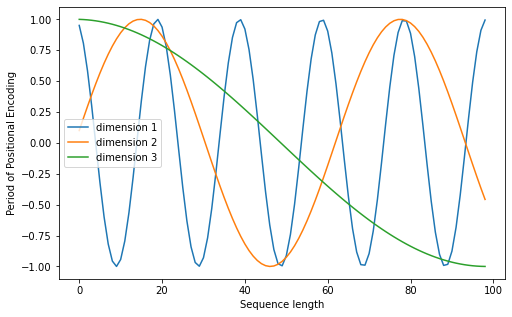

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(positional_encoding[1:100, 1], label="dimension 1")
plt.plot(positional_encoding[1:100, 2], label="dimension 2")
plt.plot(positional_encoding[1:100, 3], label="dimension 3")
plt.legend()
plt.xlabel("Sequence length")
plt.ylabel("Period of Positional Encoding")

X: [batch_size, len, embedding_size]  
W: [embedding_size, hidden_dimension]  
XW = [batch_size, len, hidden_dimension]  

## 2. $self \ attention \ mechanism$, **自注意力机制**;

![](./imgs/attention_0.jpg)
![](./imgs/attention_1.jpg)

### Attention Mask

![](./imgs/attention_mask.jpg)

注意, 在上面$self \ attention$的计算过程中, 我们通常使用$mini \ batch$来计算, 也就是一次计算多句话, 也就是$X$的维度是$[batch \ size, \ sequence \ length]$, $sequence \ length$是句长, 而一个$mini \ batch$是由多个不等长的句子组成的, 我们就需要按照这个$mini \ batch$中最大的句长对剩余的句子进行补齐长度, 我们一般用$0$来进行填充, 这个过程叫做$padding$.   
但这时在进行$softmax$的时候就会产生问题, 回顾$softmax$函数$\sigma (\mathbf {z} )_{i}={\frac {e^{z_{i}}}{\sum _{j=1}^{K}e^{z_{j}}}}$, $e^0$是1, 是有值的, 这样的话$softmax$中被$padding$的部分就参与了运算, 就等于是让无效的部分参与了运算, 会产生很大隐患, 这时就需要做一个$mask$让这些无效区域不参与运算, 我们一般给无效区域加一个很大的负数的偏置, 也就是:
$$z_{illegal} = z_{illegal} + bias_{illegal}$$
$$bias_{illegal} \to -\infty$$
$$e^{z_{illegal}} \to 0 $$
经过上式的$masking$我们使无效区域经过$softmax$计算之后还几乎为$0$, 这样就避免了无效区域参与计算.


## 3. $Layer \ Normalization$和残差连接.

1). **残差连接**:   
我们在上一步得到了经过注意力矩阵加权之后的$V$, 也就是$Attention(Q, \ K, \ V)$, 我们对它进行一下转置, 使其和$X_{embedding}$的维度一致, 也就是$[batch \ size, \ sequence \ length, \ embedding \ dimension]$, 然后把他们加起来做残差连接, 直接进行元素相加, 因为他们的维度一致:   
$$X_{embedding} + Attention(Q, \ K, \ V)$$
在之后的运算里, 每经过一个模块的运算, 都要把运算之前的值和运算之后的值相加, 从而得到残差连接, 训练的时候可以使梯度直接走捷径反传到最初始层:
$$X + SubLayer(X) \tag{eq. 5}$$
2). $LayerNorm$:   
$Layer Normalization$的作用是把神经网络中隐藏层归一为标准正态分布, 也就是$i.i.d$独立同分布, 以起到加快训练速度, 加速收敛的作用:
$$\mu_{i}=\frac{1}{m} \sum^{m}_{i=1}x_{ij}$$
上式中以矩阵的行$(row)$为单位求均值;
$$\sigma^{2}_{j}=\frac{1}{m} \sum^{m}_{i=1}
(x_{ij}-\mu_{j})^{2}$$
上式中以矩阵的行$(row)$为单位求方差;
$$LayerNorm(x)=\alpha \odot \frac{x_{ij}-\mu_{i}}
{\sqrt{\sigma^{2}_{i}+\epsilon}} + \beta \tag{eq.6}$$
然后用**每一行**的**每一个元素**减去**这行的均值**, 再除以**这行的标准差**, 从而得到归一化后的数值, $\epsilon$是为了防止除$0$;   
之后引入两个可训练参数$\alpha, \ \beta$来弥补归一化的过程中损失掉的信息, 注意$\odot$表示元素相乘而不是点积, 我们一般初始化$\alpha$为全$1$, 而$\beta$为全$0$.

## 4. $transformer \ encoder$整体结构.   

经过上面3个步骤, 我们已经基本了解到来$transformer$编码器的主要构成部分, 我们下面用公式把一个$transformer \ block$的计算过程整理一下:    
1). 字向量与位置编码:   
$$X = EmbeddingLookup(X) + PositionalEncoding \tag{eq.2}$$
$$X \in \mathbb{R}^{batch \ size  \ * \  seq. \ len. \  * \  embed. \ dim.} $$
2). 自注意力机制:   
$$Q = Linear(X) = XW_{Q}$$ 
$$K = Linear(X) = XW_{K} \tag{eq.3}$$
$$V = Linear(X) = XW_{V}$$
$$X_{attention} = SelfAttention(Q, \ K, \ V) \tag{eq.4}$$
3). 残差连接与$Layer \ Normalization$
$$X_{attention} = X + X_{attention} \tag{eq. 5}$$
$$X_{attention} = LayerNorm(X_{attention}) \tag{eq. 6}$$
4). 下面进行$transformer \ block$结构图中的**第4部分**, 也就是$FeedForward$, 其实就是两层线性映射并用激活函数激活, 比如说$ReLU$:   
$$X_{hidden} = Activate(Linear(Linear(X_{attention}))) \tag{eq. 7}$$
5). 重复3).:
$$X_{hidden} = X_{attention} + X_{hidden}$$
$$X_{hidden} = LayerNorm(X_{hidden})$$
$$X_{hidden} \in \mathbb{R}^{batch \ size  \ * \  seq. \ len. \  * \  embed. \ dim.} $$

**小结:**   
我们到现在位置已经讲完了transformer的编码器的部分, 了解到了transformer是怎样获得自然语言的位置信息的, 注意力机制是怎样的, 其实举个语言情感分类的例子, 我们已经知道, 经过自注意力机制, 一句话中的每个字都含有这句话中其他所有字的信息, 那么我们可不可以添加一个空白字符到句子最前面, 然后**让句子中的所有信息向这个空白字符汇总, 然后再映射成想要分的类别呢?** 这就是**BERT**, 我们下次会讲到.   
在**BERT**的预训练中, 我们给每句话的句头加一个特殊字符, 然后句末再加一个特殊字符, 之后模型预训练完毕之后, 我们就可以用句头的特殊字符的$hidden \ state$完成一些分类任务了.